# PCA GPR Analysis

In [1]:
%load_ext autoreload

In [18]:
# Imports
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import joblib
import csv
import warnings
import seaborn as sns
import openpyxl
from scipy import stats

# Ignore warnings
warnings.filterwarnings("ignore")

# Py File Imports
from supporting_functions import get_fp, loadData, saveData, loadPCA

# Sklearn Imports
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, ConstantKernel
from sklearn.model_selection import LeaveOneOut, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Get Correct Filepath
#cpu = "surface"
cpu = "man_dtop"
#cpu = "sean"


folder_fp, data_fp, figures_fp = get_fp(cpu, figuresFolder="4.gprPCA/")
rawPhys, rawRheo, physDict, rheoDict, imputedRheo = loadData(data_fp)
pca_model, X_pca = loadPCA(data_fp)

In [3]:
# Clean NA from Rheological Data
cleanedRheo = rawRheo
# Remove Ibservation from Donor M
#cleanedRheo = cleanedRheo[cleanedRheo["donors"] != "M"]

# Define Targets
rheo_targets = ["MU_0", "MU_INF", "TAU_C", "T_R1", "T_R2", "MU_R", "SIGMA_Y0", "TAU_LAM", "G_R", "G_C"]
rheo_targets_latex = [r"$\mu_0$", r"$\mu_{\infty}$", r"$\tau_C$", r"$T_{R^1}$", r"$T_{R^2}$", r"$\mu_R$", r"$\sigma_{Y^{0}}$", r"$\tau_{\lambda}$", r"$G_R$", r"$G_C$"]
rheo_columns = [value["column_name"] for value in rheoDict.values()][1::]

In [ ]:
def create_robust_gpr_model():
    """Create GPR optimized for small datasets with many features"""
    # Use simpler kernel with higher regularization
    kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1)
    
    gpr = GaussianProcessRegressor(
            kernel=RBF(1.0) + WhiteKernel(0.1),
            alpha = 5.0,
            normalize_y=True,
            n_restarts_optimizer=1,
            random_state=1776
        )
    return gpr

In [5]:
def evaluate_model_small_dataset(X, y, model_name="GPR"):
    """Model evaluation optimized for small datasets"""
    
    # Data validation
    if np.any(np.isnan(y)) or np.any(np.isnan(X)):
        return {'r2_cv': np.nan, 'status': 'NAN_VALUES'}
    
    if np.var(y) < 1e-10:
        return {'r2_cv': 0.0, 'status': 'ZERO_VARIANCE'}
    
    try:
        # Create model
        model = create_robust_gpr_model()
        
        # Use 5-fold CV first (more stable than LOO for small datasets)
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        cv_scores_5fold = cross_validate(
            model, X, y, 
            cv=kf,
            scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
            return_train_score=True
        )
        
        cv_scores = cv_scores_5fold
        cv_method = "5-Fold"
        
        # Fit full model
        model.fit(X, y)
        y_pred = model.predict(X)
        y_pred_full, y_std = model.predict(X, return_std=True)
        
        # Calculate metrics
        mse = -cv_scores['test_neg_mean_squared_error'].mean()
        mae = -cv_scores['test_neg_mean_absolute_error'].mean()
        r2_cv = cv_scores['test_r2'].mean()
        r2_train = r2_score(y, y_pred)
        
        results = {
            'model': model,
            'mse_cv': mse,
            'mae_cv': mae,
            'r2_cv': r2_cv,
            'r2_train': r2_train,
            'y_pred': y_pred_full,
            'y_std': y_std,
            'cv_scores': cv_scores,
            'cv_method': cv_method,
            'status': 'SUCCESS'
        }
        
        return results
        
    except Exception as e:
        return {
            'model': None, 'mse_cv': np.nan, 'mae_cv': np.nan, 'r2_cv': np.nan,
            'r2_train': np.nan, 'y_pred': np.full_like(y, np.nan), 'y_std': np.full_like(y, np.nan),
            'cv_scores': None, 'status': f'FAILED: {str(e)[:50]}'
        }

print("Robust GPR functions defined!")

Robust GPR functions defined!


In [6]:
# Test different numbers of components
n_components_to_test = [3, 5, 7, 8, 10]
cv_scores = {}

# Define X as PCA components
X = X_pca
optimal_components = 3

# Define y_data as rheological targets
y_data = imputedRheo[rheo_columns].values

print("Testing PCA components with 5-Fold Cross Validation:")
print("-" * 50)

for n_comp in n_components_to_test:
    X_reduced = X[:, :n_comp]  # Use first n components
    ratio = X_reduced.shape[0] / X_reduced.shape[1]
    
    # Test with first target (mu_0)
    y_test = y_data[:, 0]  # mu_0
    
    gpr = GaussianProcessRegressor(
        kernel=RBF(1.0) + WhiteKernel(0.1),
        alpha=1e-2,  # Higher regularization
        normalize_y=True,
        n_restarts_optimizer=2,
        random_state=42
    )
    
    # 5-fold CV evaluation
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(gpr, X_reduced, y_test, cv=kf, scoring='r2')
    
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    
    print(f"{n_comp} components (ratio: {ratio:.2f}) - R²: {mean_score:.4f} ± {std_score:.4f}")
    
    # Store results if valid
    if not np.any(np.isnan(scores)):
        cv_scores[n_comp] = mean_score

X_optimal = X[:, :optimal_components]


Testing PCA components with 5-Fold Cross Validation:
--------------------------------------------------
3 components (ratio: 7.33) - R²: -0.9852 ± 1.2122
5 components (ratio: 4.40) - R²: -2.3651 ± 2.9646
7 components (ratio: 3.14) - R²: -1.1598 ± 1.2465
8 components (ratio: 2.75) - R²: -1.1039 ± 1.2248
10 components (ratio: 2.20) - R²: -1.1038 ± 1.2248


In [7]:
# Use optimal number of components
X_final = X_optimal

# Dictionary to store all results
all_results_fixed = {}
summary_stats_fixed = []

print(f"Running FIXED GPR Analysis with {X_final.shape[1]} PCA components")
print("="*60)

for i, target in enumerate(rheo_columns):
    print(f"\nProcessing {target}...")
    
    # Get target values
    y = y_data[:, i]
    
    print(f"  Target variance: {np.var(y):.2e}")
    
    # Run evaluation with fixed settings
    results = evaluate_model_small_dataset(X_final, y, target)
    
    # Store results
    all_results_fixed[target] = results
    
    # Collect summary statistics
    summary_stats_fixed.append({
        'Target': target,
        'R²_CV': results['r2_cv'],
        'R²_Train': results['r2_train'],
        'MSE_CV': results['mse_cv'],
        'MAE_CV': results['mae_cv'],
        'Overfitting': results['r2_train'] - results['r2_cv'] if not pd.isna(results['r2_cv']) else np.nan,
        'CV_Method': results.get('cv_method', 'Unknown'),
        'Status': results['status']
    })
    
    if results['status'] == 'SUCCESS':
        print(f"  ✅ SUCCESS - R²_CV: {results['r2_cv']:.4f} ({results.get('cv_method', 'Unknown')})")
    else:
        print(f"  ❌ FAILED - {results['status']}")

print(f"\n" + "="*60)
successful_models = len([s for s in summary_stats_fixed if s['Status'] == 'SUCCESS'])
print(f"ANALYSIS COMPLETE: {successful_models}/{len(summary_stats_fixed)} models successful")
print("="*60)

Running FIXED GPR Analysis with 3 PCA components

Processing mu_0 (Pa s)...
  Target variance: 7.08e-06
  ✅ SUCCESS - R²_CV: -0.9852 (5-Fold)

Processing mu_inf (Pa s)...
  Target variance: 3.30e-07
  ✅ SUCCESS - R²_CV: -0.5146 (5-Fold)

Processing tau_C (s)...
  Target variance: 3.71e-04
  ✅ SUCCESS - R²_CV: -0.5605 (5-Fold)

Processing t_r1 (s)...
  Target variance: 3.32e-01
  ✅ SUCCESS - R²_CV: -0.3988 (5-Fold)

Processing t_r2 (s)...
  Target variance: 4.31e-03
  ✅ SUCCESS - R²_CV: -5.5856 (5-Fold)

Processing mu_R (Pa s)...
  Target variance: 6.42e-04
  ✅ SUCCESS - R²_CV: -0.5097 (5-Fold)

Processing sigma_y0 (Pa)...
  Target variance: 2.81e-06
  ✅ SUCCESS - R²_CV: -0.0750 (5-Fold)

Processing tau_lam (s)...
  Target variance: 5.77e-01
  ✅ SUCCESS - R²_CV: -1.2763 (5-Fold)

Processing G_R (Pa)...
  Target variance: 4.21e-01
  ✅ SUCCESS - R²_CV: -11.3060 (5-Fold)

Processing G_C (Pa)...
  Target variance: 6.98e-02
  ✅ SUCCESS - R²_CV: -10.3760 (5-Fold)

ANALYSIS COMPLETE: 10/10 mod

In [8]:
# Create summary DataFrame
summary_df_fixed = pd.DataFrame(summary_stats_fixed)

print("FIXED RHEOLOGICAL PARAMETER PREDICTION SUMMARY")
print("="*60)
print(f"Dataset size: {X_final.shape[0]} samples")
print(f"PCA components used: {X_final.shape[1]} (reduced from {X.shape[1]})")
print(f"Sample-to-feature ratio: {X_final.shape[0]/X_final.shape[1]:.2f}")
print("\nPER-TARGET PERFORMANCE:")
print("-"*60)

for _, row in summary_df_fixed.iterrows():
    print(f"\n{row['Target']}")
    if row['Status'] == 'SUCCESS':
        print(f"  Cross-Val R²:     {row['R²_CV']:.4f} ({row['CV_Method']})")
        print(f"  Training R²:      {row['R²_Train']:.4f}")
        print(f"  Overfitting Gap:  {row['Overfitting']:.4f}")
        print(f"  CV MSE:           {row['MSE_CV']:.6f}")
        print(f"  CV MAE:           {row['MAE_CV']:.6f}")
    else:
        print(f"  Status:           {row['Status']}")

# Summary statistics for successful models
successful_results = summary_df_fixed[summary_df_fixed['Status'] == 'SUCCESS']

if len(successful_results) > 0:
    print("\n" + "="*60)
    print("OVERALL SUMMARY STATISTICS:")
    print("-"*60)
    print(f"Successful models:    {len(successful_results)}/{len(summary_df_fixed)}")
    print(f"Mean CV R²:           {successful_results['R²_CV'].mean():.4f} ± {successful_results['R²_CV'].std():.4f}")
    print(f"Best performing:      {successful_results.loc[successful_results['R²_CV'].idxmax(), 'Target']}")
    print(f"Best R²:              {successful_results['R²_CV'].max():.4f}")
    print(f"Mean overfitting:     {successful_results['Overfitting'].mean():.4f}")

FIXED RHEOLOGICAL PARAMETER PREDICTION SUMMARY
Dataset size: 22 samples
PCA components used: 3 (reduced from 12)
Sample-to-feature ratio: 7.33

PER-TARGET PERFORMANCE:
------------------------------------------------------------

mu_0 (Pa s)
  Cross-Val R²:     -0.9852 (5-Fold)
  Training R²:      0.0000
  Overfitting Gap:  0.9852
  CV MSE:           0.000009
  CV MAE:           0.001842

mu_inf (Pa s)
  Cross-Val R²:     -0.5146 (5-Fold)
  Training R²:      0.0000
  Overfitting Gap:  0.5146
  CV MSE:           0.000000
  CV MAE:           0.000373

tau_C (s)
  Cross-Val R²:     -0.5605 (5-Fold)
  Training R²:      0.0000
  Overfitting Gap:  0.5605
  CV MSE:           0.000424
  CV MAE:           0.015644

t_r1 (s)
  Cross-Val R²:     -0.3988 (5-Fold)
  Training R²:      0.0000
  Overfitting Gap:  0.3988
  CV MSE:           0.332855
  CV MAE:           0.423652

t_r2 (s)
  Cross-Val R²:     -5.5856 (5-Fold)
  Training R²:      0.0000
  Overfitting Gap:  5.5856
  CV MSE:           0.004

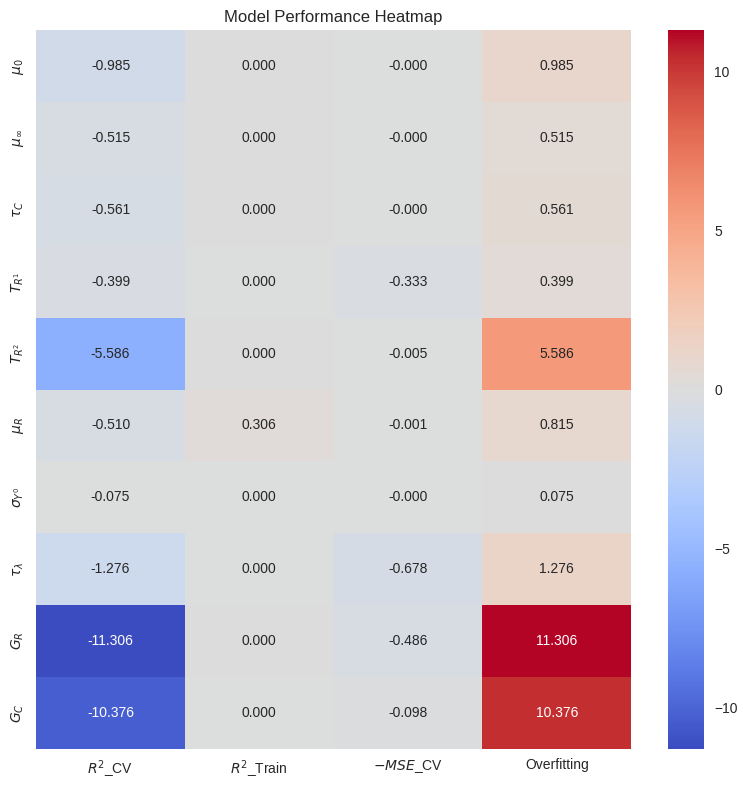

In [19]:
# Plot Set 1: Model Performance & Prediction Quality
# Filter successful results
successful_results = summary_df_fixed[summary_df_fixed['Status'] == 'SUCCESS']

# Create figure with subplots - properly define both fig and ax
plt.subplots(figsize=(8, 8))

performance_matrix = np.full((len(rheo_columns), 4), np.nan)

# Option 1: Use latex names from your dictionary
target_labels = []
for target in rheo_columns:
    # Find the key in rheoDict that matches this target
    matching_key = None
    for key, value in rheoDict.items():
        if value["column_name"] == target:
            matching_key = key
            break
    
    if matching_key:
        target_labels.append(rheoDict[matching_key]["latex_name"])
    else:
        # Fallback to cleaned version if not found in dictionary
        target_labels.append(target.replace(' (Pa s)', '').replace(' (s)', '').replace(' (Pa)', ''))
        
for i, target in enumerate(rheo_columns):
    if target in successful_results['Target'].values:
        row = successful_results[successful_results['Target'] == target].iloc[0]
        performance_matrix[i, 0] = row['R²_CV']
        performance_matrix[i, 1] = row['R²_Train']
        performance_matrix[i, 2] = -row['MSE_CV'] if not pd.isna(row['MSE_CV']) else np.nan  # Negative for better color scaling
        performance_matrix[i, 3] = row['Overfitting']


# Create the heatmap
sns.heatmap(performance_matrix, 
            xticklabels=[r'$R^2$_CV', r'$R^2$_Train', r'$-MSE$_CV', r'Overfitting'],
            yticklabels=target_labels,
            annot=True, fmt='.3f', cmap='coolwarm', center=0)
plt.title('Model Performance Heatmap')

# Adjust layout to prevent label cutoff
plt.tight_layout()
fp = figures_fp + 's4_011_gprPerformanceHeatmap.png'
plt.savefig(fp, dpi=300, bbox_inches='tight')
plt.show()
#plt.close()
